In [1]:
import proxUtil
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS

In [2]:
dir1 = "training_output"
dir2 = "training_predictions"

In [3]:
# First, we train a PF model and give it the name 'Spartacus'
# By default, this will create a number of files (names can be specified by arguments):
    #1. Spartacus.ser: the serialized trained model
    #2. ytrain.txt: the training labels, used in computing outlier scores later
    #3. ForestProximities.txt: the array of proximities
    #4. Predictions.txt: the predictions on the given test data.

proxUtil.getProx("Data/GunPoint_TRAIN.tsv", "Data/GunPoint_TEST.tsv", modelname="Spartacus", out=dir1)

#This implementation has been expanded so as to handle user-specified distance(s):
#proxUtil.getProx("Data/GunPoint_TRAIN.tsv", "Data/GunPoint_TEST.tsv", modelname="Spartacus", distances=['dtw','ddtw'])

#In particular, Euclidean distance for time-independent data
#proxUtil.getProx("Data/GunPoint_TRAIN.tsv", "Data/GunPoint_TEST.tsv", modelname="Spartacus", distances=['euclidean'])

#One can also use a python-specified distance. A file called 'PythonDistance.py' must be in the directory the .jar file is called,
    # the function must be called 'Distance' See the PythonDistance.py file for an example and acceptable call signature.
#proxUtil.getProx("Data/GunPoint_TRAIN.tsv", "Data/GunPoint_TEST.tsv", modelname="Spartacus", distances=['python'], num_trees=11)

# Similarly, one can use a function defined by a MapleDistances.mpl file (in particular, for Manifold distances)
#proxUtil.getProx("Data/GunPoint_TRAIN.tsv", "Data/GunPoint_TEST.tsv", modelname="Spartacus", distances=['maple'], num_trees=11)

reading file [GunPoint_TEST.tsv]:finished in 0:0:0.022
reading file [GunPoint_TRAIN.tsv]:finished in 0:0:0.004
Running on configurations...
Dataset: GunPoint_TRAIN.tsv, Training Data : 50x150 , Testing Data: 150x150, Train #Classes: 2, Test #Classes: 2
Repeats: 1 , Trees: 11 , Candidates per Split(r): 5
Output Dir: training_output/, Export: 1, Verbosity: 1
Select DM per node: true , Shuffle Data: false, JVM WarmUp: false
----------------------------------------------------------------------------------------------------

-----------------Repetition No: 1 (GunPoint_TRAIN.tsv)   -----------------
Using: 4 MB, Free: 16 MB, Allocated Pool: 20 MB, Max Available: 1024 MB
core.ProximityForestResult@4783da3f
0.1.2.3.4.5.6.7.8.9.10.
Using: 24 MB, Free: 110 MB, Allocated Pool: 134 MB, Max Available: 1024 MB
**
Computing Forest Proximities...
Done Computing Forest Proximities. Computation time: 7.0ms
Training Time: 855.729436ms (0:0:0.855)
Prediction Time: 389.656923ms (0:0:0.389)
Correct(TP+TN):

In [4]:
# Here are the predictions on the provided test set.
f0 = open(dir1 + "/Predictions.txt")
f1 = f0.read()
preds = eval("np.array(" + f1 + ")")
f0.close()

In [5]:
# We can now read a model by name and obtain predictions on another dataset. This creates:
    #1. Predictions_saved.txt: the predicted labels of the read-in model.
# Let's get predictions on the training set to illustrate.
proxUtil.evalPF("Data/GunPoint_TRAIN.tsv", modelname=dir1 + "/Spartacus", out=dir2)
# Now let's get predictions on the test set.
proxUtil.evalPF("Data/GunPoint_TEST.tsv", modelname=dir1 + "/Spartacus")

reading file [GunPoint_TRAIN.tsv]:finished in 0:0:0.012

*
reading file [GunPoint_TEST.tsv]:finished in 0:0:0.023

**


In [6]:
# Here are the predictions (of the saved model) on the training set.
f0 = open(dir2 + "/Predictions_saved.txt")
f1 = f0.read()
train_preds_saved = eval("np.array(" + f1 + ")")
f0.close()

In [7]:
# Here are the predictions (of the saved model) on the test set.
f0 = open("Predictions_saved.txt")
f1 = f0.read()
preds_saved = eval("np.array(" + f1 + ")")
f0.close()

In [8]:
print(len(train_preds_saved))
print(len(preds_saved))
print(len(preds))

50
150
150


In [9]:
# Just checking: are the outputs of the saved model equal to the original predictions?
np.unique([preds[i]-preds_saved[i] for i in range(len(preds))])

array([0])

In [10]:
# the following can be used to obtain the proximities (p) and true training labels (y)
p,y=proxUtil.getProxArrays(proxfile=dir1 + "/ForestProximities.txt", yfile=dir1 + "/ytrain.txt")

In [11]:
# The raw proximities are not symmetric. But in some applications, one desires symmetry.
p = proxUtil.SymmetrizeProx(p)

In [12]:
# The following can be used to obtain outlier scores.
# Note that these are intra-class outlier scores.
outlier_scores = proxUtil.getOutlierScores(p,y)

In [13]:
# The proximities can be used to obtain a vector embedding.
# we will prepare a visual, using size to indicate intra-class outlier-ness.
embed = MDS(n_components=2, random_state=0, dissimilarity='precomputed')
dis = (np.ones(p.shape) - p)**4
x_trans = embed.fit_transform(dis)
xt = x_trans.transpose()
sizes = [x*100 for x in outlier_scores]

/home/ben/.local/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


In [14]:
#plt.scatter(xt[0],xt[1],c=y,s=sizes)
#plt.title("MDS Embedding of the GunPoint dataset PF Proximities")
#plt.xlabel("MDS 1")
#plt.ylabel("MDS 2")
#plt.show()

In [15]:
X1 = np.array([x_trans[i] for i in range(x_trans.shape[0]) if y[i]==0]).transpose()
X2 = np.array([x_trans[i] for i in range(x_trans.shape[0]) if y[i]==1]).transpose()
eX = [X1,X2]

outs1 = np.array([sizes[i] for i in range(x_trans.shape[0]) if y[i]==0]).transpose()
outs2 = np.array([sizes[i] for i in range(x_trans.shape[0]) if y[i]==1]).transpose()
Outs = [outs1,outs2]

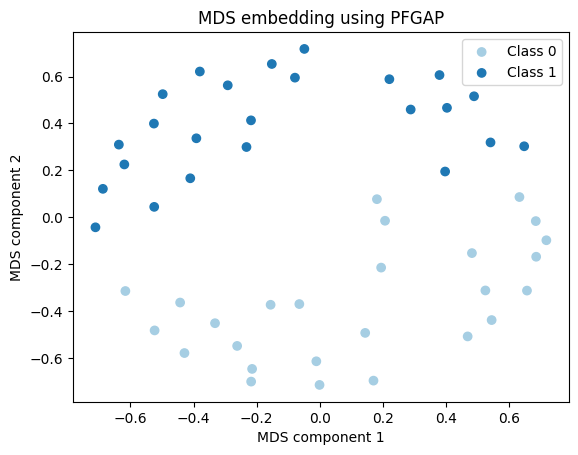

In [16]:
cmap = plt.cm.Paired
#plt.figure(figsize = (15,10))
for i in range(1,3):
    cmap1 = [i-1 for j in range(eX[i-1].shape[1])]
    #if y[np.argmax(sizes)] == i:
     #   cmap1[np.argmax(eval("outs" + str(i)))] = 5
    #plt.scatter(eX[i-1][0], eX[i-1][1], c=cmap(cmap1), s=Outs[i-1],
     #           label="Class {:g}".format(i-1))
    plt.scatter(eX[i-1][0], eX[i-1][1], c=cmap(cmap1),
                label="Class {:g}".format(i-1))
    
plt.legend()
plt.xlabel('MDS component 1')
plt.ylabel('MDS component 2')
plt.title('MDS embedding using PFGAP')
plt.show()